# Yelp data challenge - text
## Can we predict "useful" review labels?
### If companies and Yelp could identify the strongest reviewers, they could guarantee better quality reviews.
#### The Yelp dataset contains more than 6.5 million reviews. This project aims to clean the text and crunch the numbers to see if useful labels are predictable.

#### Approach
> We approach the problem with standard libraries.
- numpy
- pandas
- scikit-learn
- spaCy

> With more than six million reviews to work with, the computation space is massive. We will need a method to work with the data outside of memory space. Dask has seen remarkable development in recent years - we will be trying our hand with this.

> *Update 9/4/19:* Even with Dask and a modern PC, it was not feasible to compute on a train data set covering half of the text. This has been reduced to about one million reviews, or 15 percent of the data set. These computations are still very complex, taking an hour in some situations.
***
***
# What's in a review?
## Steps to find review value
### For this project, we define *value* as an entry containing any useful votes. 
### The three steps below will be the analyses we take to uncover value in reviews. They increase in complexity.

#### 1. Consider the count of words
> The basic bag of words and TfIdf approach is always a good start.

#### 2. Readability and length of review
> There are methods to score the readability of a document. We will dig to analyze correlation between usefulness and readability. Furthermore, we will also consider that the number of words in a review could have correlation.

#### 3. Embeddings
> Do word embeddings provide any insight? We will use the gensim library to see if we can find value or trends here.

### Combining the metrics
> Do these metrics work in tandem? We will see if we can aggregate them and produce a classification model.

### Establishing functions for project
#### For clarity and workflow, let's store the project functions at the top of the project - just like imports. This includes:
1. Fix natural language - basic text cleaning on delayed object
2. Lemmatize sentence - return a string of lemmas
3. Small frame - this project has enormous amounts of text; this provides a smaller dataframe
4. Variables - load regular variables into workspace
5. Tagger - preprocesses data into tagged documents for gensim

### Note: prefixes and following along
> *__The 'val' and 'noval' prefixes indicate value - usefulness and noval(ue).__*

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import yelp_tool # All libraries within this module
# -----------------------------------------------------------------------------------------------------------#
# new_vec = load('../../../_Storage/Data/yelp_dataset/vec.joblib')
sns.set_style('darkgrid')
laptop = '/media/seapea/Blade HDD/_Storage/Data/yelp_dataset/'
Xy_train = yelp_tool.load('Xy_train.joblib')
Xy_test = yelp_tool.load('Xy_test.joblib')
%matplotlib inline
#------------------------------------------------------------------------------------------------------------#
print("Done!")

Done!


# Dask - distributing workers
## Challenges in a distributed work environment
### Dask is a library to handle larger datasets by persisting some data on disk and some in memory.
> Throughout this project, I have found it very difficult to work with Dask. It is not covered in the course anywhere, despite being a more realistic tool when too much data exists to analyze things in memory. Arithmetic computations and other analyses across the Dask dataframe chunks pose challenges we haven't seen when operating only in memory.

Some basic issues encountered with Dask include:

- Boolean indexing
- `.loc` querying - single query returning many values, i.e. `X.loc[0]`
- `.loc` slicing - throws errors, i.e. `X.loc[:50]`
- Series `.loc` - totally non-operational
- `.iloc` slicing - distributed tables don't have an absolute index
- `spaCy` pipelines (memory allocation)
- `Word2Vec` conversions (memory allocation)
- Basic computations (very long turn around, typically 20 minutes, up to several hours)
- Limited train / test split options

> Because of these limitations, some of the work and discovery efforts behind the scenes might not be displayed in detail. Furthermore, once working through a few basics, *we have elected to use a smaller text selection so that we may work within memory.* In doing so, we are able to select about one million reviews for test and train each, using about ~15 MB a piece. *__This is a farcry from the ~5.5 GB original file, but this move is absolutely necessary, as matrix computations have only now become feasible.__*

> Nonetheless, Dask has *excellent* documentation, so we have worked through the basics and will use it again in the future.

## Other efficiency improvements: memory

### Previous attempts at spaCy
> In a previous project, I limited my vocabulary and text subset to one million words as spaCy throws an error when too large a vocabulary exists for use in memory. I have since discovered a lazy computation design for this exists within spaCy called the pipe. This allows spaCy to batch the documents and prevent breaking memory constraints. This has been a helpful discovery.

### Sparse matrices
> While sparse matrices are efficient, some computations on them at the size of this corpus will still overload memory. We must keep this in mind with any BoW or TfIdf computations.

## Persistent issues: computation times

### Oversized arrays
> When working with some arrays - in one case, the LSA conversions - the kernel catches permanently. I have decided to work with much smaller subsets of the text (as noted above), yet this does not stop the computational overload. Problems like these have caused massive delays in finishing this project. One million records and only 15 is still nothing to take lightly.

### Jupyter and kernel hang
> More than once, the kernel, the shell, or Jupyter would hang and halt the entire process, clearing variables and stopping my workflow.
***
***
## Testing the basics first

### Distribution of review ratings
> Let's try some basic Dask computations, verifying integrity and observing the distribution of review ratings.

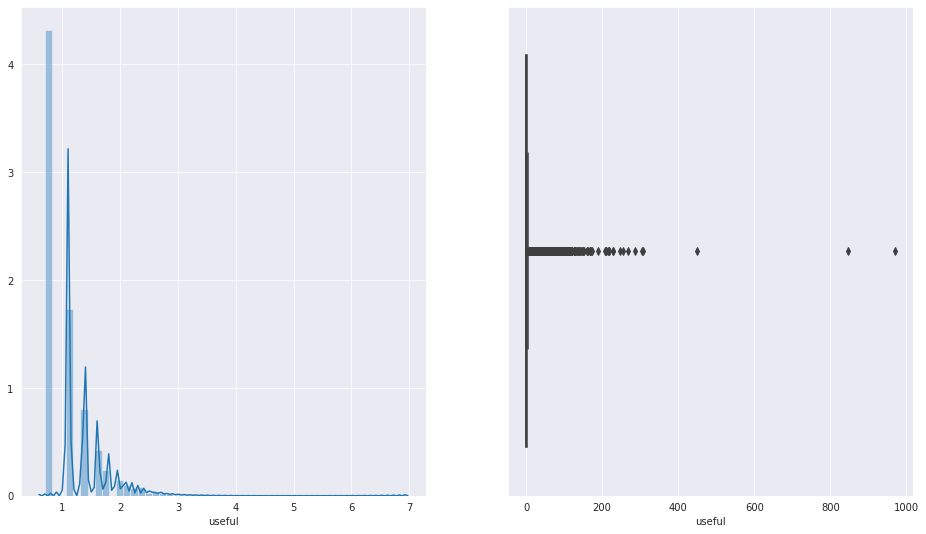

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
# Logarithms to transform the shape, adding to because there were some -1 reviews
sns.distplot(np.log((y_train + 2).compute()), ax=ax1)
sns.boxplot(y_train.compute(), ax=ax2)
ax1.set_title

### Approaching parsing of vast text
> Below is another simple task to test the library - we will try the TfidfVectorizer. 

In [7]:
# This was a quick look at the entire dataset's text features
TV = TfidfVectorizer(max_features=30)
matrix_X = TV().fit_transform(Xy_train.text.apply(fix_nl))
print(TV().get_feature_names())

['best', 'came', 'chicken', 'come', 'definitely', 'did', 'didn', 'don', 'food', 'friendly', 'good', 'got', 'great', 'just', 'like', 'little', 'love', 'nice', 'order', 'ordered', 'people', 'place', 'really', 'restaurant', 'service', 'staff', 'time', 'try', 've', 'went']


### Success! 
> Our vectorizer didn't overload the system!

### Crunching spaCy pipeline design
> We will try to run another basic vectorizer. We do this below with some preprocessing this time - the benefits of lemmatization would increase the diversity of words selected for features. The goal here is to verify the pipeline functionality.

In [412]:
# This cell will test the steps of my approach against the much smaller dataframe
df.text = df.text.apply(fix_nl)
new_txt = list(nlp.pipe(df.iloc[:5000].text))
cvec = CountVectorizer(stop_words='english', max_features=100)
cvec.fit_transform([lemma_sent(txt) for txt in new_txt])
cvec.transform([lemma_sent(txt) for txt in list(nlp.pipe(df.iloc[5000:6000].text))])

<5000x100 sparse matrix of type '<class 'numpy.int64'>'
	with 52872 stored elements in Compressed Sparse Row format>

***
***
# 1. Bag of words
## The standard starting line
### Vectorized text transformation
> While testing the pipeline function above, we are able to verify `fit_transform` functionality, and `transform` even works against new data! We will now attempt the same process against the trained features from the entire 'rev' dataset. 
>#### *Note: This vectorizer is based on half the text, an approach I later abandoned due to the computation times and memory errors. (Read introduction notes) I did save it and use it, as it is capturing the the best feature representation of a larger training set.*

Text(0.5, 1.0, 'Not useful reviews counted against 300 features from Bag of Words')

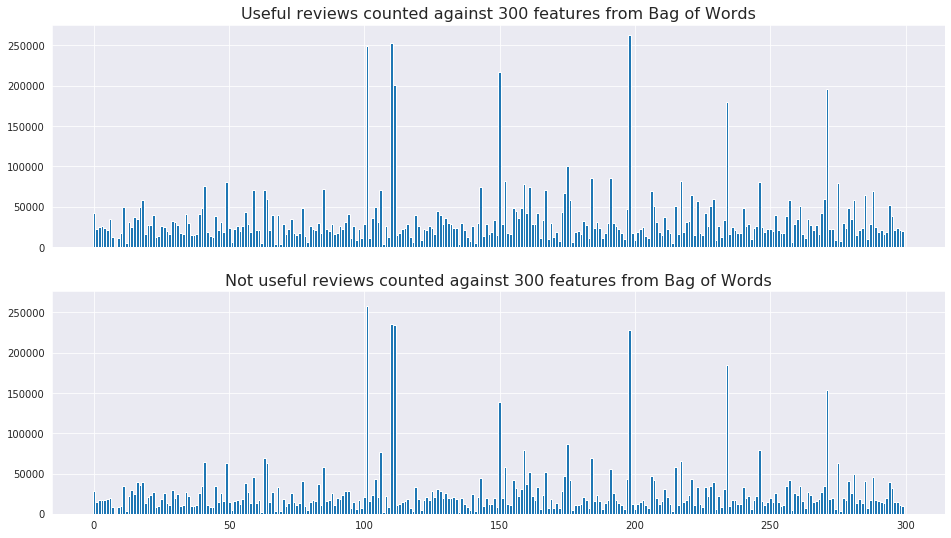

In [200]:
myX = new_vec.transform(Xy_train.text.apply(fix_nl))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9), sharey=True, sharex=True)
myInd1 = Xy_train[Xy_train.useful == True].index
myInd0 = Xy_train[Xy_train.useful == False].index

ax1.bar(range(300), np.array(myX[myInd1].sum(axis=0)).tolist()[0], width=1)
ax2.bar(range(300), np.array(myX[myInd0].sum(axis=0)).tolist()[0], width=1)
ax1.set_title('Useful reviews counted against 300 features from Bag of Words', size=16)
ax2.set_title('Not useful reviews counted against 300 features from Bag of Words', size=16)

### Visual differences 
> Visually, we are seeing striking similarities between the reviews by useful or not useful. The peaks and valleys, upon first impression, appear to be consistent. We can see that the standout features actually have significantly different values per *y* outcome. The class imbalance is only about six percent, so this is a welcome difference that might help our models.
***
***
# 2. Readability and review length
## Another strong contendor
### Will either correlate with review usefulness?
> Spacy is an excellent library. This optional pipeline component - Readability - will calculate the readability score. After a little research, I selected the Flesch-Kincaid reading ease value. This seems to have stood the test of time, accepted and modified since its rise to popularity in the 1970s.

In [201]:
# val_doc = nlp.pipe(Xy_train[Xy_train.useful == True].text)
# noval_doc = nlp.pipe(Xy_train[Xy_train.useful == False].text)
# val_read_len = [(txt._.flesch_kincaid_reading_ease, len(txt)) for txt in val_doc]
# noval_read_len = [(txt._.flesch_kincaid_reading_ease, len(txt)) for txt in noval_doc]

val_read_len = load('val_read_len.joblib')
noval_read_len = load('noval_read_len.joblib')

val_read_len = np.array(val_read_len)
noval_read_len = np.array(noval_read_len)

### Visualizing the two features
> A basic scatterplot can give us insight about the feature relationship, if any.

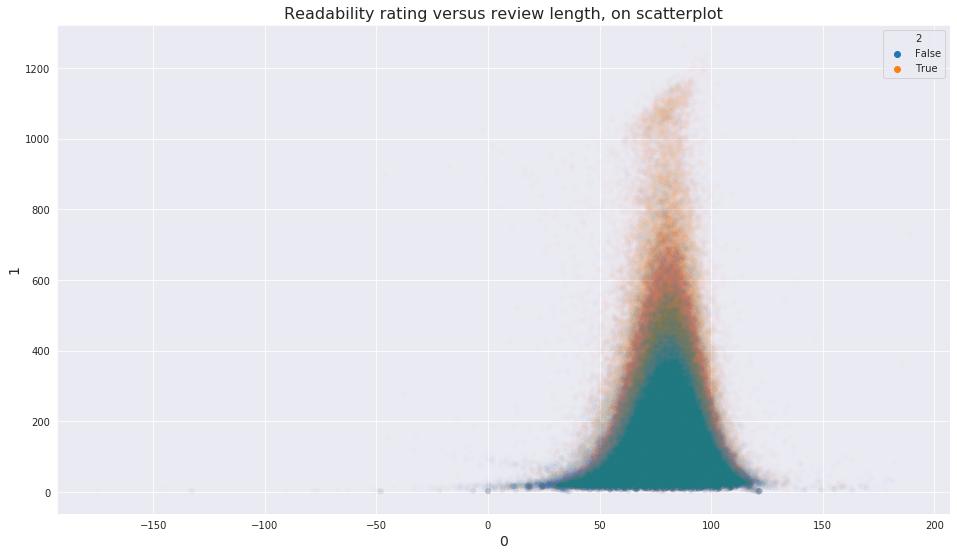

In [202]:
new1 = pd.DataFrame(val_read_len)
new1[2] = True
new2 = pd.DataFrame(noval_read_len)
new2[2] = False
frame = pd.concat([new1, new2])
other = frame[frame[0] > -200]
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title('Readability rating versus review length, on scatterplot', size=16)
ax.set_xlabel('Flesch-Kincaid reading ease rating', size=14)
ax.set_ylabel('Review length in characters', size=14)
sns.scatterplot(x=other[0], y=other[1], hue=other[2], ax=ax, alpha=.01)
plt.show()

### A trend is apparent
> Based on this scatterplot, we can deduce that a relationship exists. I have cut the extreme outliers for visualization's sake, and we can now see the less useful reviews tend to sink in this plot. Good to know.

### Note: Gladly, we haven't increased our corpus
> Once I was able to learn a little more about Dask, its limitations, and basically remove it from my workflow as described so far, I saw massive increases in computation time and progress (obviously!). I considered increasing the sample sizes of train and test after my successes, but this calculation of readability and the use of an efficient pipeline still took more than an hour. We are sticking with one million samples!
***
***
# 3. Embeddings to create features
## The most complex task
### Doc2Vec: How to handle the large corpus
> After some trial, error, and research, it is my conclusion that the model computation will not differ between one large or several chunks - one million documents is still vast. We would have to train and update the document vector model.
>
> This information comes from a blog written by the library's author - Radim Rehurek - discussing multiprocessing for faster running times. If the content can be processed in parallel, it does not require information from the entire corpus and therefore can be run in pieces.

### Verifying training updates
> We will verify if this can be done below. Within gensim, we can access the document and word vectors after training updates to see if the model updates.

In [27]:
vec1, tags1 = tag(ddf).compute()
test_arr = vec1.docvecs[0]
vec1.docvecs.most_similar(0, topn=5)

[(17033, 0.38854920864105225),
 (23295, 0.3664354085922241),
 (12518, 0.3616259694099426),
 (12915, 0.3600383400917053),
 (14743, 0.35090503096580505)]

In [28]:
vec2, tags2 = tag(rev).compute()
vec1.train(tags2, len(tags1) + len(tags2), epochs=5)
test_arr1 = vec1.docvecs[0]
vec1.docvecs.most_similar(0, topn=5)

[(17033, 0.38854920864105225),
 (23295, 0.3664354085922241),
 (12518, 0.3616259694099426),
 (12915, 0.3600383400917053),
 (14743, 0.35090503096580505)]

In [31]:
# Every single value in array is equal!!!
sum(test_arr != test_arr1)

0

### Basic retraining failed
> It appears the document vectors within the model are *not* returning different results when compared with the `most_similar` method. I did see this somewhere but wanted to verify. We can verify the document vectors themselves are not different, as shown when comparing the test arrays. This is further reinforced via Google queries and documentation, showing `Doc2Vec` does not allow the same training update approach that word vectors allow. We will have to work with the embeddings differently.

### gensim `LsiModel`
> We also tried the vanilla LSI approach with weak results - displayed below. We will return to other gensim options as this is not promising.

In [4]:
lsa_df = []
for corp, use in zip(mycorp, Xy_train.useful):
    lsa_df.append([ele[1] for ele in model[corp]])

clf_gbc = yelp_tool.GradientBoostingClassifier()
clf_gbc.fit(X=df.drop(columns='useful'), y=df.useful)

def tester(n):
    df = Xy_test.sample(n)
    mycorp_t = [mydct.doc2bow(yelp_tool.fix_nl(txt).split()) for txt in df.text]

    lsa_df = []
    for corp in mycorp_t:
        lsa_df.append([ele[1] for ele in model[corp]])
        
    try:    
        return clf_gbc.score(X=yelp_tool.pd.DataFrame(lsa_df), y=df.useful)
    except:
        return yelp_tool.np.NAN

results = []
for i in range(500):
    results.append(tester(50))

yelp_tool.pd.Series(results).describe()

count    292.000000
mean       0.625548
std        0.069801
min        0.400000
25%        0.580000
50%        0.620000
75%        0.660000
max        0.800000
dtype: float64

### `Similarity` in gensim
> We are actually able to use a different similarity mathematic behind the scences if we dig deeper. Within the library, I discovered there are faster ways to model the text with Latent Semantic Indexing, then put text into the reduced space and calculate vectors. The heart of this is at the 'Similarity' object.

### To use it properly, we follow these steps:
>1. Create gensim Dictionary
2. Create corpus of tuples
3. Create LSI model consisting of each input
4. Query the index with tuple doc2bow object and fit it into the vector space

### Manually graphing 
> As we have seen in the past, manually graphing LSA into two spaces is not as visually informative. The major reason for this is the restriction on the values the mathematics causes; it does not move and recenter the data - as PCA would. This weakness is demonstrated below; the distribution resembles a cone.

Text(0.5, 1.0, 'LSA representation of text')

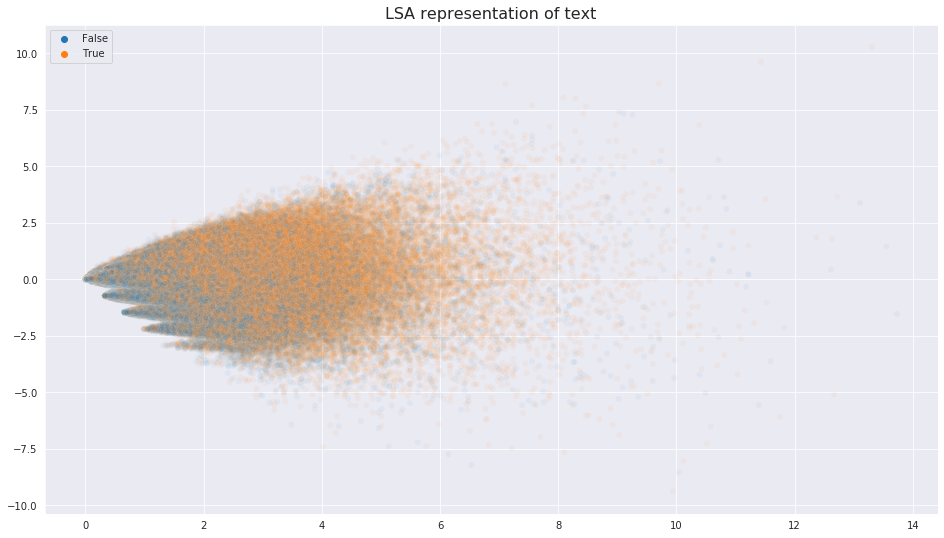

In [35]:
# sklearn tool faster than [fix_nl(txt).split] for txt in rev.text.compute()])
# mydct variable saved for future
mydct = Dictionary([new_vec.get_feature_names()])
mycorp = [mydct.doc2bow(fix_nl(txt).split()) for txt in X_train.compute()]
mylsi_2 = LsiModel(mycorp, id2word=mydct, num_topics=2)
LSA2 = [mylsi_2[bow] for bow in mycorp]

x = []
y = []
hue = []

for val, h in zip(LSA2, (y_train > 0).compute()):
    try:
        x.append(val[0][1])
        y.append(val[1][1])
        hue.append(h)
    except:
        pass

fig, ax = plt.subplots(figsize=(16,9))
sns.scatterplot(x=x, y=y, hue=hue, alpha=0.05)
ax.set_title('LSA representation of text', size=16)

### LSI Cone
> As I have seen in other projects with text, LSI tends to be limited in visual reproduction.

### 20 LSI features
> Let's save 20 LSI features (it isn't much, but higher numbers have created computational obstacles), and then pump those into the TSNE object of SKlearn. This is generally a better visualization method when discussing many dimensions. Maybe that will give us insight if we are treading properly.

Text(0.5, 1.0, 'TSNE transformation of train data')

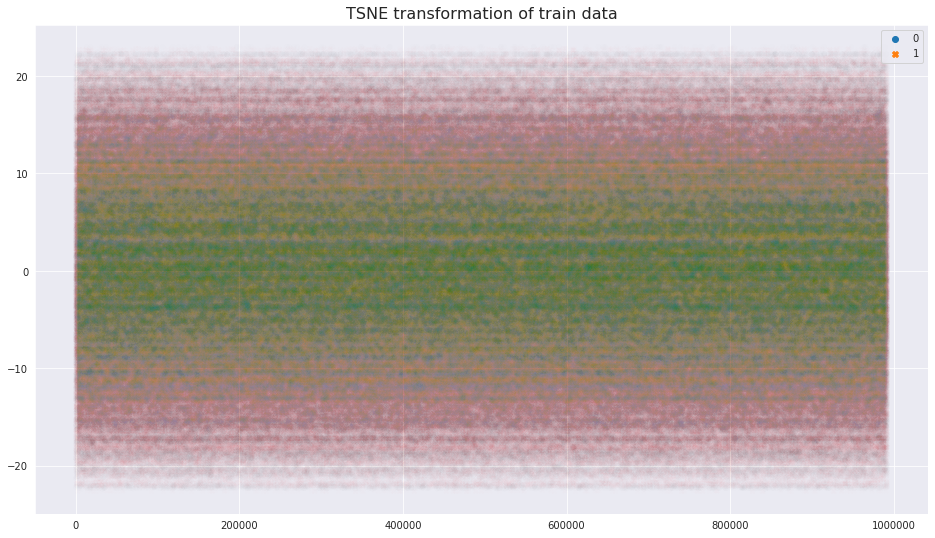

In [47]:
mydct = load('mydct.joblib')
mycorp = [mydct.doc2bow(fix_nl(txt).split()) for txt in X_train.compute()]
mylsi_20 = LsiModel(mycorp, id2word=mydct, num_topics=50)
LSA20 = [mylsi_20[bow] for bow in mycorp]

LSA20_array = []

for i, val in enumerate(LSA20):
    try:
        LSA20_array.append(np.asarray(LSA20[i])[:,1])
    except:
        pass
    
tsne = TSNE()
transformed = tsne.fit_transform(X=np.asarray(LSA20_array))

fig, ax = plt.subplots(figsize=(16,9))
sns.scatterplot(data=transformed, hue=(y_train > 0).compute(), alpha=0.003)
ax.set_title('TSNE transformation of train data', size=16)

### TSNE also not providing much...
> The transformation abuve uses a different embedding trick, but it also struggles to linearly (or otherwise) separate the classes. *However,* we are seeing a nice color and gradient change near the horizontal middle; even though the values are thicker here, the color becomes more green and less red / purple. This indicates a stronger presence of orange - or the positive class - sitting in the middle. Interesting!

### What is happening below? 
> Since we see some success with decomposition, let's try to capture similarity to all documents by converting them into similarity ratings and reducing the feature space with PCA. We access this with the aforementioned `gensim.similarities.Similarity` module.

In [20]:
sample = "I happened to eat here twice in two days.\n\nThe lunch menu is 5 stars!  For an app, we ordered guacamole, which they make in front of you at your table (I always love that).  It was one of the best guacamoles I've ever had!  \nI got huevros rancheros and it was so good.  I cleared my plate!!  \n\nThe dinner menu wasn't as good  IMO, but it still offered a good selection of items I would order.  I wound up getting the veggie burrito.  It was ok - there wasn't any beans in it which I was kind of surpised about.  Usually veggie burritos = black bean burritos in my experience.  My margarita wasn't the best by any means.  I think I'll have the fajitas if I come back for dinner."
mydct = load('mydct.joblib')
mycorp = [mydct.doc2bow(fix_nl(txt).split()) for txt in X_train.compute()]
myind = get_tmpfile('index')
index = Similarity(myind, mycorp, len(mydct))
index[mydct.doc2bow(fix_nl(sample).split())]

/home/seapea/anaconda3/envs/py36/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


array([0.06085806, 0.11508708, 0.        , ..., 0.14990634, 0.        ,
       0.        ], dtype=float32)

### Checking the sample text against our model
> We can see that we can index the text (in the proper format) against out model and finally observe some document similarities! What we are given is a cosine similarity rating against each document in the index (each training review). If we build an index of useful and not useful text corpuses, we can look at similarities across each.

### Build two separate LSI models
> Since we know the similarity query works, let's compare the text to both useful and not useful indices, then return cosine similarities. This will create more than 400,000 and 500,000 features - respectively - so it will need further steps afterward, I'm thinking Principal Component Analysis. **We will join the features in a way so we can load them into a single classification model later.**

In [62]:
# Verify gensim objects are in order and empty lists for Xs and ys
mydct = Dictionary([new_vec.get_feature_names()])
noval_sims_X = []
val_sims_X = []
both_sims_y = []
# --------------------------------------------------------------------------------------------------------- #
# Build corpus bodies
noval_corp = [mydct.doc2bow(fix_nl(txt).split()) for txt in Xy_train[Xy_train.useful == False].text]
val_corp = [mydct.doc2bow(fix_nl(txt).split()) for txt in Xy_train[Xy_train.useful == True].text]

# Build the indices
noval_ind = get_tmpfile('index')
noval_index = Similarity(noval_ind, noval_corp, len(mydct))
val_ind = get_tmpfile('index')
val_index = Similarity(val_ind, val_corp, len(mydct))

# Populate X and y - sample from pandas forces us to persist
for row in Xy_train.sample(frac=0.001).itertuples():
    noval_sims_X.append(noval_index[mydct.doc2bow(fix_nl(row.text).split())])
    val_sims_X.append(val_index[mydct.doc2bow(fix_nl(row.text).split())])
    both_sims_y.append(row.useful)

print("-----------------------------------------------Done!-------------------------------------------------")

-----------------------------------------------Done!-------------------------------------------------


## Further steps - dimensionality problems; what about decomposition?
### How much variance is captured by PCA?
> With hundreds of thousands of features, we are in desparate need of dimension reduction to avoid the curse of dimensionality. The AUC graph below shows roughly 10 features will capture enough variance - the elbow is visible in the plot.

Text(0.5, 1.0, 'PCA Explained Variance Ratio curve')

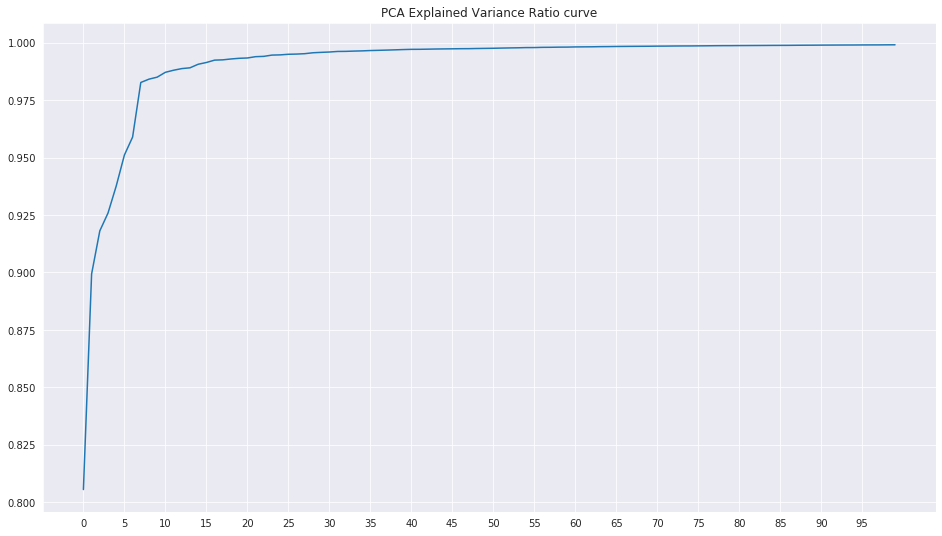

In [41]:
noval_sims_X, noval_index, val_sims_X, val_index, both_sims_y = vars()
pca100 = PCA(n_components=100)
pca100_X = pca.fit_transform(comb_X)

fig, ax = plt.subplots(figsize=(16,9))
ax.set_xticks(range(0, 100, 5))
plt.plot(1 - pca100.explained_variance_ratio_)
plt.title('PCA Explained Variance Ratio curve')

In [9]:
# Train our models on the train data
read_len = load('read_len.joblib')
read_len = read_len.reset_index().drop('index', axis=1)

# both_sims_y = np.array(load('both_sims_y.joblib'))
clf_log_vec = LogisticRegression()
clf_log_vec.fit(X=pca_X, y=both_sims_y)
clf_log_rnl = LogisticRegression()
clf_log_rnl.fit(X=read_len[[0,1]], y=read_len[2])
print("-----------------------------------------------Done!-------------------------------------------------")

/home/seapea/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/seapea/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


-----------------------------------------------Done!-------------------------------------------------


# 4. Combining predictions
## Will we have 'useful' or 'noval' results?
### (That's the best pun, I've got, folks.)
> Now, we can bring it all together.
### Using logistic regression
> We are combining two-class logistic regression classifiers into a single classifier. We can not use bagging, boosting, or other classifier ensemble methods, as I originally intended. These algorithms rely on homogenous inputs, or features; our classifiers are built off of two varying sets. Summarizing, they are:
> 1. Readability and length features
2. PCA compressed LSA vectors
>
> To capture all of the indexing, embedding, and other preprocessing, we will build three classifiers from our two approaches. They will be:
> - Probabilities from the not useful corpus, in indexed, LSI, vector space 
- Same notion above, *but indexed against the useful corpus*
- Readability and length classifier probabilities
>
> That brings our total to three, and we will treat each classifier equally and simply sum up the probabilities. Let's begin.

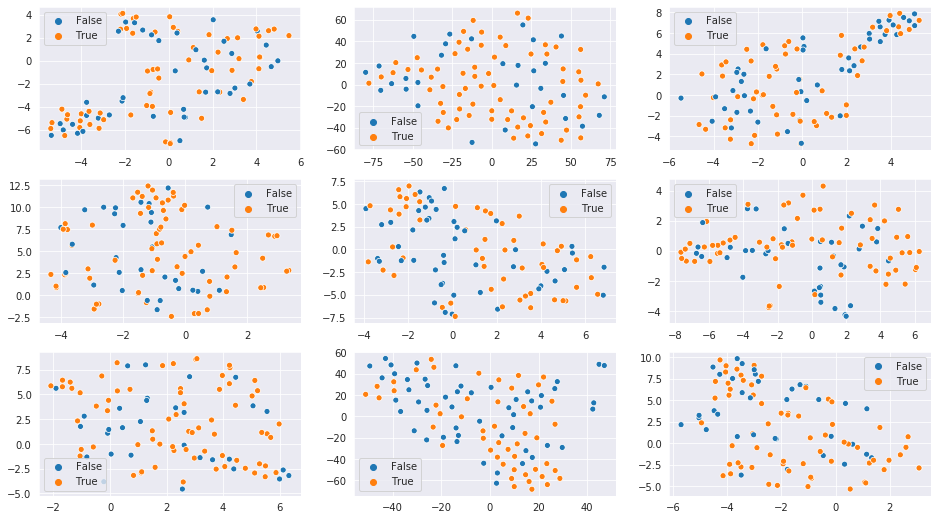

In [50]:
'''
CELL READY DO NOT RUN
CELL READY DO NOT RUN
CELL READY DO NOT RUN'''

fig, ax = plt.subplots(3, 3, figsize=(16,9))

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    
    for val_r in range(0, 3):
        for val_c in range(0, 3):
            s = my_pre(Xy_test, 100)
            sns.scatterplot(x=s['graph'][:,0], y=s['graph'][:,1], hue=s['success'], ax=ax[val_r][val_c])

# ax.title.set_text('Samples of test data, colored by successful classification', size=16)

## Scattered
### A spread of varying scatter plots
> Above we have nine different test samples plotted in TSNE scatter with colors of True or False for correctly labeled data. This is nice to see, as the plots are all quite different in distribution and accuracy.
>
> The scatterplots above, however, do not provide any insight about trends. Let's run a single, large test and observe the predictions versus actual classes.

/home/seapea/anaconda3/envs/py36/lib/python3.6/site-packages/gensim/similarities/docsim.py:517: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.hstack(shard_results)


Text(0.5, 1.0, 'Predicted values')

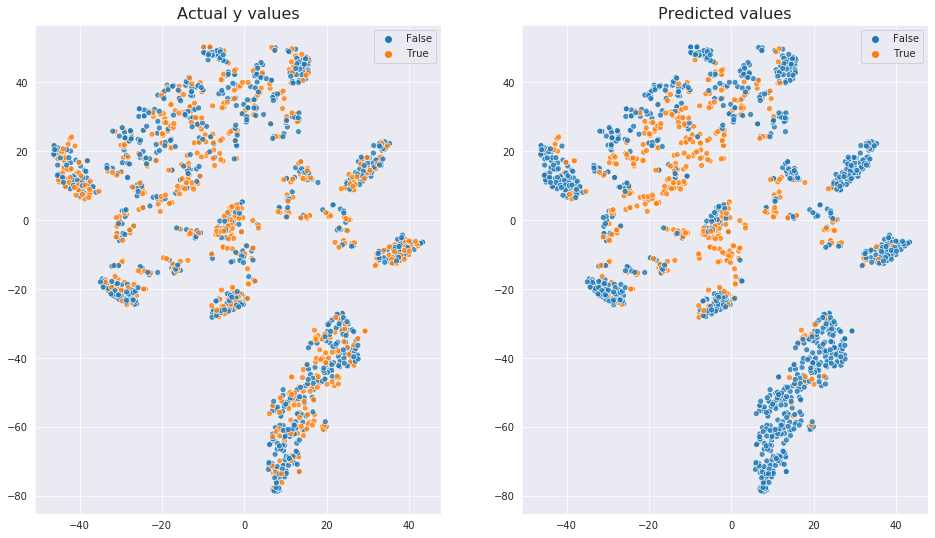

In [11]:
'''
CELL READY DO NOT RUN
CELL READY DO NOT RUN
CELL READY DO NOT RUN'''

s = my_pre(Xy_test, 1500)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
sns.scatterplot(x=s['graph'][:,0], y=s['graph'][:,1], hue=s['y'], alpha=0.8, ax=ax1)
sns.scatterplot(x=s['graph'][:,0], y=s['graph'][:,1], hue=s['pred'], alpha=0.8, ax=ax2)
ax1.set_title('Actual y values', size=16)
ax2.set_title('Predicted values', size=16)

## Scatterplots: TSNE and predictions, actuals on 1,500 text samples
### Nice visualization, capturing a lot - but how informative is it?
> We aren't able to determine many specifics from the scatterplots above, but what can we tell?
>
> 1. Predicted classifications are occurring in more clustered fashion that actuals
2. Our model tends to vote the review is 'noval'
3. Correct classifications don't seem terrible, but how is it actually behaving?
>
> Our last plot - below - will analytically visualize successful classifications. We will run many predictions on random samples of 30, then plot the numbers.

Text(0.5, 1.0, 'Distribution of 1,000 tests - with sample size of 30')

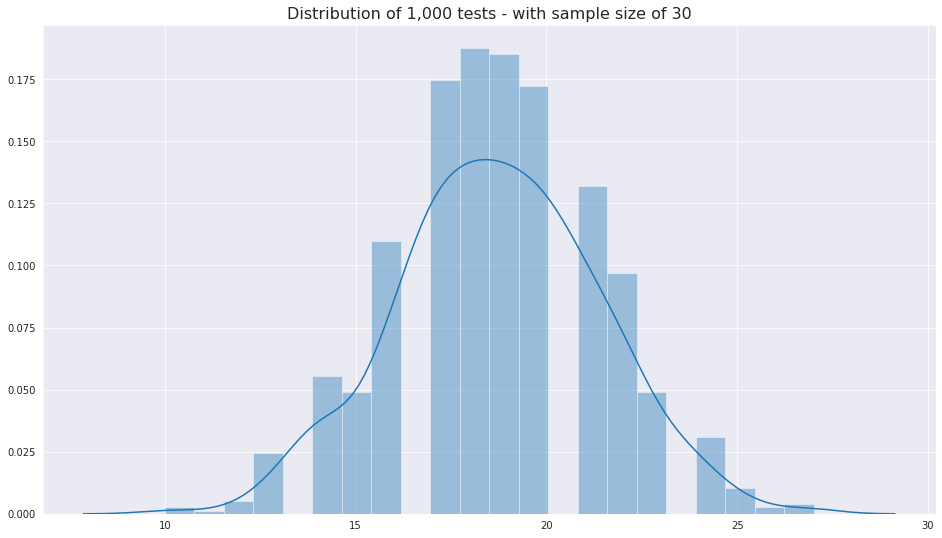

In [12]:
'''
CELL READY DO NOT RUN
CELL READY DO NOT RUN
CELL READY DO NOT RUN'''
import warnings

success_samples = []
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)

    for val in range(1000):
        s = my_pre(Xy_test, 30)
        success_samples.append(s['success'].sum())
    
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(success_samples)
ax.set_title('Distribution of 1,000 tests - with sample size of 30', size=16)

## Beating random chance
### The distribution above is promising
> This distribution of samples is not amazing - it's true. This is not a cutting edge classifier; rather it is somewhat elementary, adding the votes of two regressions. The peak is sitting around 19/30, or about 63 percent, but the impressive part is the collective success of the model. It is very consistently achieving better than 50 percent.
### Different models - GradientBoostingClassifier
> The GBC is known to be a strong performer - let's give it a shot.
## SKLearn - GBC

In [8]:
mydct, noval_index, val_index, pca8, nlp = yelp_tool.vars()
X_train, y_train, read_len_train = yelp_tool.preproc(Xy_train, 3000, nlp, noval_index, val_index, mydct, pca8)

clf_gbc_vec = yelp_tool.GradientBoostingClassifier()
clf_gbc_rnl = yelp_tool.GradientBoostingClassifier()

clf_gbc_vec.fit(X_train, y_train)
clf_gbc_rnl.fit(read_len_train, y_train)

# yelp_tool.dump(clf_gbc_vec, 'clf_gbc_vec.joblib')
# yelp_tool.dump(clf_gbc_rnl, 'clf_gbc_rnl.joblib')

/home/seapea/anaconda3/envs/py36/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/seapea/anaconda3/envs/py36/lib/python3.6/site-packages/gensim/similarities/docsim.py:517: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.hstack(shard_results)


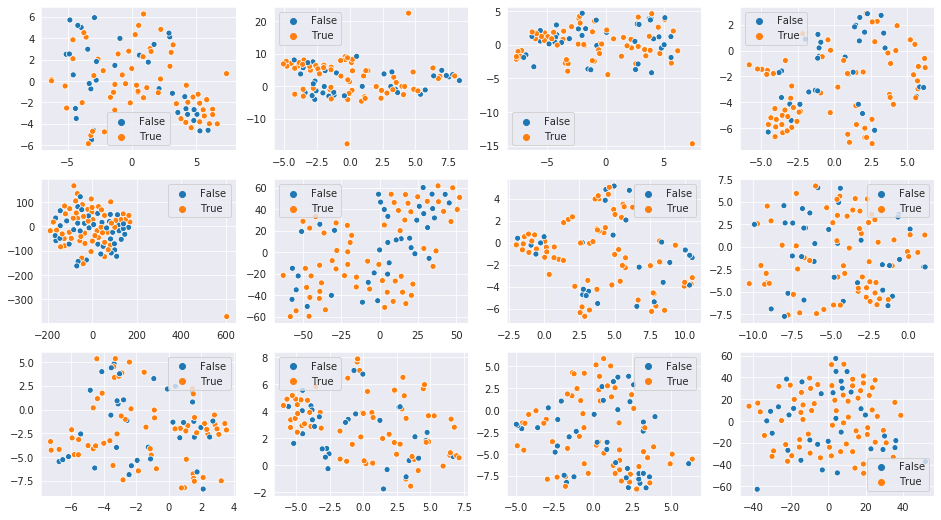

In [30]:
fig, ax = plt.subplots(3, 4, figsize=(16,9))

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    
    for val_r in range(0, 3):
        for val_c in range(0, 4):
            X_test, y_test, read_len_test = yelp_tool.preproc(Xy_test, 100, nlp, noval_index, val_index, mydct, pca8)
            s = yelp_tool.modeler(X_test, y_test, read_len_test, clf_gbc_vec, clf_gbc_rnl)
            sns.scatterplot(x=s['graph'][:,0], y=s['graph'][:,1], hue=s['success'], ax=ax[val_r][val_c])

### Accuracies looking alright, but still no separation
> We still aren't seeing any linearly separable sections in the visualizations. This would be a nice addition, but the reduction from hundred thousands to eight to two could be the cause of that.

Text(0.5, 1.0, 'Predicted values')

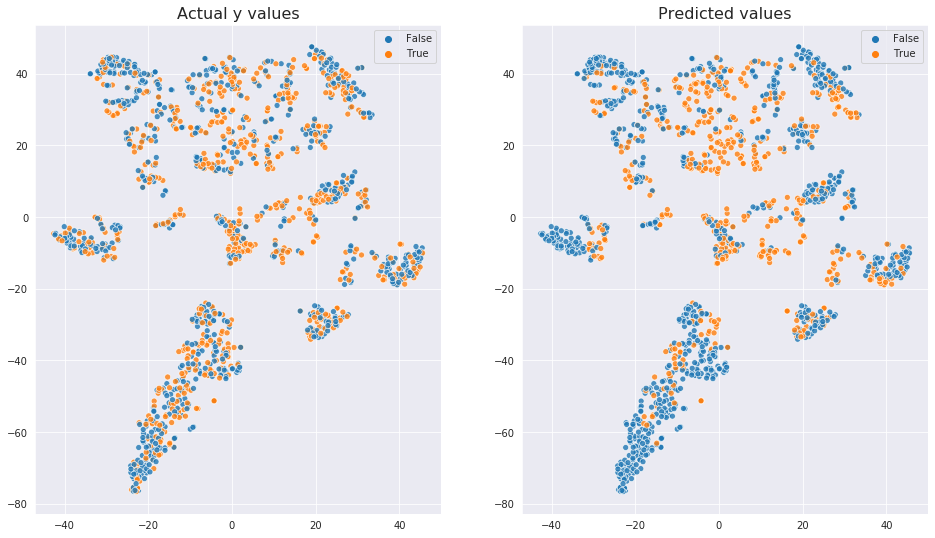

In [25]:
X_test, y_test, read_len_test = yelp_tool.preproc(Xy_test, 1500, nlp, noval_index, val_index, mydct, pca8)
score_dict = yelp_tool.modeler(X_test, y_test, read_len_test, clf_gbc_vec, clf_gbc_rnl)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
sns.scatterplot(x=score_dict['graph'][:,0], y=score_dict['graph'][:,1], hue=score_dict['y'], alpha=0.8, ax=ax1)
sns.scatterplot(x=score_dict['graph'][:,0], y=score_dict['graph'][:,1], hue=score_dict['pred'], alpha=0.8, ax=ax2)
ax1.set_title('Actual y values', size=16)
ax2.set_title('Predicted values', size=16)

### Better accuracy here
> The accuracy on the TSNE visualization does look to do better than the original on Logistic Regression. I did double the training size and use a new model, so this could be a step in the right direction.

Text(0.5, 1.0, 'Distribution of 1,000 tests - with sample size of 50')

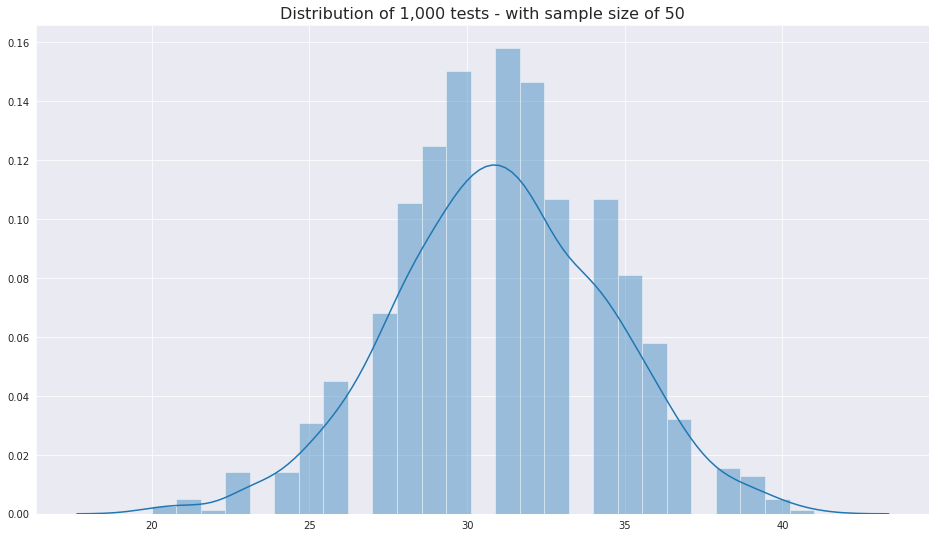

In [29]:
import warnings

success_samples = []
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)

    for val in range(1000):
        X_test, y_test, read_len_test = yelp_tool.preproc(Xy_test, 50, nlp, noval_index, val_index, mydct, pca8)
        s = yelp_tool.modeler(X_test, y_test, read_len_test, clf_gbc_vec, clf_gbc_rnl)
        success_samples.append(s['success'].sum())
    
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(success_samples)
ax.set_title('Distribution of 1,000 tests - with sample size of 50', size=16)

### GBC performance
> The second model looks to do about the same - we even ran it through more samples to verify. Its performance sits at about 61 percent average proper classification; it could use some improvements.


# 5. Conclusions
## A long, difficult, but educational project
### Thoughts
> #### Computation times
> This was the biggest problem. I drastically understimated the requirements of one million reviews, as this put a permanent hold on my workflow. Very good experience. I will *never* forget the commitments of a corpus this large.
>
> #### Unable to run ensemble classifiers
> With two different data inputs, I wasn't able to run an ensemble on the data. Going back, I would first determine the best way to join different models before proceeding.
>
> #### Further steps
> TENSORS. With many inputs available via LSI, I would like to delve into another similar project with the intention of preprocessing for tensors into a deep learning package. (This was an original intent, yet time did not permit.)

## Thanks!